In [31]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import sys
import os
import torch
import torch.nn.functional as F


In [32]:
# class_names = train_dataset.classes  # ['anomaly', 'normal']

# data_iter = iter(train_loader)
# images, labels = next(data_iter)

# plt.figure(figsize=(5, 5))
# for i in range(16):
#     plt.subplot(4, 4, i + 1)
#     img = images[i].permute(1, 2, 0)
#     label = class_names[labels[i]]
#     plt.imshow(img)
#     plt.title(label)
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

# Method 1, flatten the input as a long array. 

In [33]:
# # 1) Check folder contents
# import os

# print("Train split:")
# for cls in ("normal","anomaly"):
#     p = f"../split_anomaly_dataset/train/{cls}"
#     cnt = len([f for f in os.listdir(p) if f.lower().endswith(('.jpg','.png'))]) \
#           if os.path.isdir(p) else 0
#     print(f"  {cls:7s}: {cnt} files")

# # 2) Load with allow_empty
# from torchvision import datasets, transforms

# tf = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
# train_ds = datasets.ImageFolder("../split_anomaly_dataset/train", transform=tf, allow_empty=True)
# print("Classes loaded:", train_ds.classes)
# print("Number of samples:", len(train_ds))


In [34]:
# # %% [markdown]
# # # DAGMM Anomaly Detection with Sampled Anomalies in Train

# # %% [code]
# # 1) Make your DAGMM code importable
# import sys, os
# from pathlib import Path
# sys.path.insert(0, str(Path.cwd().parent / "Appropriate_dagmm"))

# # %% [code]
# # 2) Imports
# import torch
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# from torchvision import transforms, datasets
# from collections import Counter

# from model import DAGMM  # your revised model.py

# # %% [code]
# # 3) Data transforms & loaders (images → flattened vectors)
# transform = transforms.Compose([
#     transforms.Resize((64,64)),
#     transforms.ToTensor(),
# ])

# train_ds = datasets.ImageFolder("../split_anomaly_dataset/train", transform=transform, allow_empty=True)
# test_ds  = datasets.ImageFolder("../split_anomaly_dataset/test",  transform=transform)

# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
# test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, drop_last=False)

# # Print ground‑truth counts
# print("Train class counts:", {train_ds.classes[k]: v for k,v in Counter(train_ds.targets).items()})
# print("Test  class counts:", {test_ds.classes[k]: v for k,v in Counter(test_ds.targets).items()})

# # %% [code]
# # 4) Model + optimizer
# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
# n_features = 3 * 64 * 64

# model = DAGMM(
#     input_dim        = n_features,
#     latent_dim       = 10,
#     n_gmm_components = 5,
#     comp_kwargs      = {'hidden_dims':[128,64], 'activation':torch.nn.Tanh},
#     est_kwargs       = {'hidden_dims':[32],      'activation':torch.nn.ReLU, 'dropout':0.3},
#     device           = device
# ).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # %% [code]
# # 5) Training loop
# n_epochs = 30
# for epoch in range(1, n_epochs+1):
#     model.train()
#     running_loss = 0.0
#     for imgs, _ in train_loader:
#         x = imgs.view(imgs.size(0), -1).to(device)  # flatten
#         out  = model(x)
#         loss = model.loss_function(x, out)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * x.size(0)
#     avg_loss = running_loss / len(train_loader.dataset)
#     print(f"Epoch {epoch}/{n_epochs} — avg train loss: {avg_loss:.4f}")

# # %% [code]
# # 6) Scoring test set & thresholding
# model.eval()
# energies = []
# with torch.no_grad():
#     for imgs, _ in test_loader:
#         x = imgs.view(imgs.size(0), -1).to(device)
#         energies.append(model(x)['energy'].cpu())
# energies = torch.cat(energies)

# # 95th‐percentile threshold
# thr = energies.quantile(0.80)
# mask = energies > thr
# print(f"Detected anomalies in test set: {mask.sum().item()} / {len(energies)}")

# # %% [code]
# # 7) (Optional) Visualize
# import matplotlib.pyplot as plt
# plt.hist(energies.numpy(), bins=50, alpha=0.7)
# plt.axvline(thr, color='r', linestyle='--', label='95% threshold')
# plt.legend(); plt.title("Test Energy Distribution"); plt.show()


In [35]:
# import torch
# from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# # 1) Recompute energies **and** collect true labels in the same order
# model.eval()
# energies = []
# y_true   = []
# with torch.no_grad():
#     for imgs, labels in test_loader:
#         x = imgs.view(imgs.size(0), -1).to(device)
#         energies.append(model(x)['energy'].cpu())
#         y_true.append(labels)
# energies = torch.cat(energies)         # shape [N_test]
# y_true   = torch.cat(y_true)           # shape [N_test]

# # 2) Choose a threshold (you could sweep this on a val set)
# thr = energies.quantile(0.95)

# # 3) Build binary predictions: 1=anomaly, 0=normal
# y_pred = (energies > thr).int()

# # 4) Confusion matrix & classification report
# print("Confusion matrix:")
# print(confusion_matrix(y_true, y_pred))
# print("Accuracy")
# print(f"Accuracy: {100 * (y_true == y_pred).float().mean():.2f}%")
# print("\nClassification report:")
# print(classification_report(y_true, y_pred, target_names=test_ds.classes))

# # 5) (Optional) AUC of the energy scores
# auc = roc_auc_score(y_true, -energies)  # we invert since lower energy = more normal
# print(f"\nROC‑AUC (energy as score): {auc:.3f}")


In [36]:
# # get top‑k highest‑energy samples
# k = 5
# idx = torch.topk(energies, k=k).indices

# # grab their file paths & labels
# for i in idx:
#     path, label = test_ds.samples[i]
#     print(f"{path}  →  label={test_ds.classes[label]}, energy={energies[i]:.3f}")


# Method 2, use cnn based architecture 

In [37]:
# 0) Point to your CNN‑DAGMM folder *before* any imports
import sys, importlib
from pathlib import Path

cnn_dir = Path.cwd().parent / "cnn_dagmm"
sys.path.insert(0, str(cnn_dir))

# 1) Import & force‑reload to clear any old cache
import compression_network, model
importlib.reload(compression_network)
importlib.reload(model)

# 2) Verify you’re using the right files
print("CompressionNetwork from:", compression_network.__file__)
print("DAGMM   from:",           model.__file__)


CompressionNetwork from: /Users/aryan/Desktop/Academics /Semester 4/Data science/Project/gmm_anomalydetection/cnn_dagmm/compression_network.py
DAGMM   from: /Users/aryan/Desktop/Academics /Semester 4/Data science/Project/gmm_anomalydetection/cnn_dagmm/model.py


Train class counts: {'normal': 284}
Test  class counts: {'anomaly': 20, 'normal': 95}
tensor(0.1607, grad_fn=<AddBackward0>) tensor(850.0509, grad_fn=<MeanBackward0>) tensor(459.9996, grad_fn=<SumBackward0>)
tensor(0.1492, grad_fn=<AddBackward0>) tensor(794.5782, grad_fn=<MeanBackward0>) tensor(459.2724, grad_fn=<SumBackward0>)
tensor(0.1193, grad_fn=<AddBackward0>) tensor(677.5420, grad_fn=<MeanBackward0>) tensor(458.4882, grad_fn=<SumBackward0>)
tensor(0.1143, grad_fn=<AddBackward0>) tensor(615.7064, grad_fn=<MeanBackward0>) tensor(457.6715, grad_fn=<SumBackward0>)
tensor(0.1042, grad_fn=<AddBackward0>) tensor(559.9345, grad_fn=<MeanBackward0>) tensor(456.8568, grad_fn=<SumBackward0>)
tensor(0.0946, grad_fn=<AddBackward0>) tensor(524.4995, grad_fn=<MeanBackward0>) tensor(456.0298, grad_fn=<SumBackward0>)
tensor(0.0991, grad_fn=<AddBackward0>) tensor(546.5284, grad_fn=<MeanBackward0>) tensor(455.1743, grad_fn=<SumBackward0>)
tensor(0.0839, grad_fn=<AddBackward0>) tensor(472.1880, grad

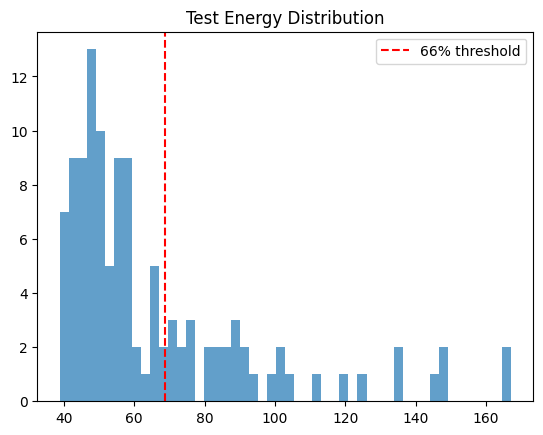

In [38]:
# %% [markdown]
# # DAGMM Anomaly Detection with Sampled Anomalies in Train

# %% [code]
# 1) Make your DAGMM code importable
import sys, os
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent / "cnn_dagmm"))

# %% [code]
# 2) Imports
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from collections import Counter

from model import DAGMM  # your revised model.py

# %% [code]
# 3) Data transforms & loaders (images → flattened vectors)
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

train_ds = datasets.ImageFolder("../split_anomaly_dataset/train", transform=transform, allow_empty=True)
test_ds  = datasets.ImageFolder("../split_anomaly_dataset/test",  transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, drop_last=False)

# Print ground‑truth counts
print("Train class counts:", {train_ds.classes[k]: v for k,v in Counter(train_ds.targets).items()})
print("Test  class counts:", {test_ds.classes[k]: v for k,v in Counter(test_ds.targets).items()})

# %% [code]
# 4) Model + optimizer
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
n_features = 3 * 64 * 64

model = DAGMM(
    input_dim        = 3 * 64 * 64,     # still required by signature but not forwarded to CompressionNetwork
    latent_dim       = 90,
    n_gmm_components = 5,
    comp_kwargs      = {'latent_dim': 90},  # now cleanly matches CompressionNetwork
    est_kwargs       = {'hidden_dims': [128], 'activation': torch.nn.Tanh, 'dropout': 0.3},
    device           = device
).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# %% [code]
# 5) Training loop
n_epochs = 50
for epoch in range(1, n_epochs+1):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        x = imgs.to(device) 
        out  = model(x)
        loss = model.loss_function(x, out)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs} — avg train loss: {avg_loss:.4f}")

# %% [code]
# 6) Scoring test set & thresholding
model.eval()
energies = []
with torch.no_grad():
    for imgs, _ in test_loader:
        x = imgs.to(device)
        energies.append(model(x)['energy'].cpu())
energies = torch.cat(energies)

# 95th‐percentile threshold
thr = energies.quantile(0.70)
mask = energies > thr
print(f"Detected anomalies in test set: {mask.sum().item()} / {len(energies)}")
# y_pred_inv = (~(energies > thr)).int() #we want 1 for normal, 0 for anomaly. High energy = anomaly. 
# y_pred = y_pred_inv.int() # 0 for normal, 1 for anomaly
# %% [code]
# 7) (Optional) Visualize
import matplotlib.pyplot as plt
plt.hist(energies.numpy(), bins=50, alpha=0.7)
plt.axvline(thr, color='r', linestyle='--', label='66% threshold')
plt.legend(); plt.title("Test Energy Distribution"); plt.show()

In [39]:
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1) Recompute energies and collect true labels
model.eval()
energies = []
y_true   = []
with torch.no_grad():
    for imgs, labels in test_loader:
        x = imgs.to(device)                       # CNN takes [B,3,64,64]
        out = model(x)
        energies.append(out['energy'].cpu())      # [B]
        y_true.append(labels)
energies = torch.cat(energies)                  # [N_test]
y_true   = torch.cat(y_true)                    # [N_test]

# 2) Identify top 30% highest‐energy samples as anomalies
#    70th percentile cutoff → top 30% above this
thr = energies.quantile(0.84)


# 3) Predictions
y_pred_inv = (~(energies > thr)).int() #we want 1 for normal, 0 for anomaly. High energy = anomaly. 
y_pred = y_pred_inv.int() # 0 for normal, 1 for anomaly
# 4) Metrics
print("Threshold for top 30% anomalies:", thr.item())
print("\nConfusion matrix:")
print(confusion_matrix(y_true, y_pred))

acc = (y_true == y_pred).float().mean() * 100
print(f"\nAccuracy: {acc:.2f}%\n")

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=test_ds.classes))

# 5) ROC‑AUC (still informative even though we fix the cutoff by proportion)
auc = roc_auc_score(y_true, -energies)  # invert since lower energy = more normal
print(f"\nROC‑AUC (energy as score): {auc:.3f}")


Threshold for top 30% anomalies: 88.08541870117188

Confusion matrix:
[[11  9]
 [ 8 87]]

Accuracy: 85.22%

Classification report:
              precision    recall  f1-score   support

     anomaly       0.58      0.55      0.56        20
      normal       0.91      0.92      0.91        95

    accuracy                           0.85       115
   macro avg       0.74      0.73      0.74       115
weighted avg       0.85      0.85      0.85       115


ROC‑AUC (energy as score): 0.847


In [40]:
# # %% [code]
# # Hyperparameter grid search for DAGMM
# import itertools
# import pandas as pd
# import torch
# from torch.utils.data import DataLoader
# from torchvision import transforms, datasets
# from model import DAGMM

# # 1) Data loaders (reuse from above)
# transform = transforms.Compose([
#     transforms.Resize((64,64)),
#     transforms.ToTensor(),
# ])
# train_ds = datasets.ImageFolder("../split_anomaly_dataset/train", transform=transform, allow_empty=True)
# test_ds  = datasets.ImageFolder("../split_anomaly_dataset/test",  transform=transform)
# train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  drop_last=True)
# test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, drop_last=False)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # 2) Define search space
# param_grid = {
#     "latent_dim":       [2, 5, 10],
#     "n_gmm_components": [2, 4, 6],
#     "est_hidden":       [[32], [64, 32]],
#     "dropout":          [0.1, 0.3],
#     "lr":               [1e-3, 1e-4],
# }

# # 3) Helper to train & evaluate one config
# def run_experiment(cfg):
#     # build model
#     model = DAGMM(
#         input_dim        = 3*64*64,
#         latent_dim       = cfg["latent_dim"],
#         n_gmm_components = cfg["n_gmm_components"],
#         comp_kwargs      = {"latent_dim": cfg["latent_dim"]},
#         est_kwargs       = {
#             "input_dim": cfg["latent_dim"]+2,
#             "output_dim": cfg["n_gmm_components"],
#             "hidden_dims": cfg["est_hidden"],
#             "activation": torch.nn.ReLU,
#             "dropout": cfg["dropout"]
#         },
#         device=device
#     ).to(device)
#     opt = torch.optim.Adam(model.parameters(), lr=cfg["lr"])

#     # train for fixed epochs
#     for epoch in range(1, 11):
#         model.train()
#         for imgs, _ in train_loader:
#             x = imgs.to(device)
#             out = model(x)
#             loss = model.loss_function(x, out)
#             opt.zero_grad(); loss.backward(); opt.step()

#     # evaluate: compute energy scores & threshold at 90th percentile
#     model.eval()
#     energies, y_true = [], []
#     with torch.no_grad():
#         for imgs, labels in test_loader:
#             x = imgs.to(device)
#             energies.append(model(x)["energy"].cpu())
#             y_true.append(labels)
#     energies = torch.cat(energies)
#     y_true   = torch.cat(y_true)

#     thr = energies.quantile(0.9)
#     y_pred = (energies > thr).int()
#     acc = (y_pred == y_true).float().mean().item()

#     return acc

# # 4) Run grid search
# results = []
# for vals in itertools.product(*param_grid.values()):
#     cfg = dict(zip(param_grid.keys(), vals))
#     acc = run_experiment(cfg)
#     print(f"Config {cfg} → accuracy {acc:.3f}")
#     results.append({**cfg, "accuracy": acc})

# # 5) Summarize
# df = pd.DataFrame(results)
# print("\nTop 5 configs by accuracy:")
# print(df.sort_values("accuracy", ascending=False).head())


In [41]:
# df.sort_values("accuracy", ascending=False).head()

In [42]:
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# import matplotlib.pyplot as plt
# from model import DAGMM

# # 1) Synthesize 100 images
# white_imgs   = torch.ones(80, 3, 64, 64)
# colored_imgs = torch.zeros(20, 3, 64, 64); colored_imgs[:,0] = 1.0
# labels       = torch.cat([torch.zeros(80), torch.ones(20)]).long()

# # single dataset
# dataset = TensorDataset(torch.cat([white_imgs, colored_imgs], 0), labels)

# # train loader (shuffle)
# train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# # eval loader (no shuffle)
# eval_loader  = DataLoader(dataset, batch_size=16, shuffle=False)

# # 2) Build & train DAGMM
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = DAGMM(
#     input_dim=3*64*64, latent_dim=2, n_gmm_components=2,
#     comp_kwargs={'latent_dim':2},
#     est_kwargs ={
#         'input_dim': 2+2,
#         'output_dim': 2,
#         'hidden_dims':[4],
#         'activation':torch.nn.ReLU,
#         'dropout':0.1
#     },
#     device=device
# ).to(device)
# opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# # 3) Train on white only
# for epoch in range(1, 51):
#     model.train()
#     total_loss = 0.0
#     n_whites = 0
#     for x_batch, y_batch in train_loader:
#         mask = (y_batch == 0)
#         if not mask.any():
#             continue
#         x = x_batch[mask].to(device)
#         out = model(x)
#         loss = model.loss_function(x, out)
#         opt.zero_grad()
#         loss.backward()
#         opt.step()

#         total_loss += loss.item() * x.size(0)
#         n_whites   += x.size(0)

#     if epoch % 10 == 0 and n_whites > 0:
#         print(f"Epoch {epoch:02d} — avg white-loss: {total_loss / n_whites:.4f}")

# # 4) Compute energies & collect labels
# model.eval()
# energies = []
# labels_list = []
# with torch.no_grad():
#     for x_batch, y_batch in eval_loader:
#         x = x_batch.to(device)
#         out = model(x)
#         energies.append(out['energy'].cpu())
#         labels_list.append(y_batch)

# energies = torch.cat(energies)     # [100]
# labels   = torch.cat(labels_list)  # [100]

# # 5) Inspect distributions by label
# white_e = energies[labels == 0]
# red_e   = energies[labels == 1]

# print("White  μ±σ:", white_e.mean().item(), white_e.std().item())
# print("Red    μ±σ:",   red_e.mean().item(),   red_e.std().item())

# plt.hist(white_e, bins=20, alpha=0.6, label='white')
# plt.hist(red_e,   bins=20, alpha=0.6, label='red')
# plt.legend(); plt.show()

# # 6) Mid-point threshold
# thr = (white_e.mean() + red_e.mean()) / 2
# pred = (energies > thr).int()

# print("Detected anomalies:", pred[labels==1].sum().item(), "/ 20")
# print("False positives:   ", pred[labels==0].sum().item(), "/ 80")


In [43]:
# import numpy as np
# from sklearn.metrics import roc_curve, f1_score, precision_recall_fscore_support

# # assume `energies` [100] and `labels` [100] (0=white,1=red)
# y_true = labels.numpy()
# y_score = energies.numpy()

# # 1) ROC curve and optimal threshold at max (TPR–FPR)
# fpr, tpr, thresholds = roc_curve(y_true, y_score)
# opt_idx = np.argmax(tpr - fpr)
# opt_thr = thresholds[opt_idx]
# print(f"Optimal threshold from ROC: {opt_thr:.4f} (TPR={tpr[opt_idx]:.2f}, FPR={fpr[opt_idx]:.2f})")

# # 2) Build predictions & compute metrics
# y_pred = (energies > opt_thr).int().numpy()
# tp, fp, fn, tn = (
#     ((y_true==1)&(y_pred==1)).sum(),
#     ((y_true==0)&(y_pred==1)).sum(),
#     ((y_true==1)&(y_pred==0)).sum(),
#     ((y_true==0)&(y_pred==0)).sum(),
# )
# print("Confusion matrix:")
# print(f"  [[TP={tp}, FP={fp}]\n   [FN={fn}, TN={tn}]]")

# precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
# print(f"\nPrecision (white,red): {precision}")
# print(f"Recall    (white,red): {recall}")
# print(f" F1‑score (white,red): {f1}")

# # 3) (Optional) print overall F1
# print(f"\nOverall F1: {f1_score(y_true, y_pred):.2f}")


In [44]:
import os
import random
from PIL import Image, ImageDraw
from tqdm import tqdm

# Setup
IMG_SIZE = 64
NORMAL_SHAPES = ['circle', 'square']
NORMAL_COLORS = ['red', 'green', 'blue']
NUM_NORMAL = 200
NUM_ANOMALY = 20
OUTPUT_DIR = "dataset"
SEED = 42
random.seed(SEED)

# Utility: Create folders
def make_dirs():
    for split in ['train', 'test']:
        for cls in ['normal', 'anomalous']:
            os.makedirs(os.path.join(OUTPUT_DIR, split, cls), exist_ok=True)

# Generate a normal image
def generate_normal_image():
    img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), 'black')
    draw = ImageDraw.Draw(img)
    shape = random.choice(NORMAL_SHAPES)
    color = random.choice(NORMAL_COLORS)
    x0, y0, x1, y1 = 16, 16, 48, 48

    if shape == 'circle':
        draw.ellipse([x0, y0, x1, y1], fill=color)
    elif shape == 'square':
        draw.rectangle([x0, y0, x1, y1], fill=color)

    return img

# Generate an anomalous image
def generate_anomalous_image():
    img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), 'black')
    choice = random.choice(['noise', 'triangle'])

    if choice == 'noise':
        pixels = img.load()
        for i in range(IMG_SIZE):
            for j in range(IMG_SIZE):
                val = random.randint(0, 255)
                pixels[i, j] = (val, val, val)
    else:
        draw = ImageDraw.Draw(img)
        draw.polygon([(32, 10), (50, 50), (14, 50)], fill='white')
    return img

# Save image
def save_image(img, split, cls, idx):
    path = os.path.join(OUTPUT_DIR, split, cls, f"{cls}_{idx:03d}.png")
    img.save(path)

# Main generation logic
def generate_dataset():
    make_dirs()

    # TRAIN: 100 normal
    print("Generating training set...")
    for i in tqdm(range(100)):
        img = generate_normal_image()
        save_image(img, 'train', 'normal', i)

    # TEST: 100 normal + 20 anomalous
    print("Generating test set...")
    for i in tqdm(range(100)):
        img = generate_normal_image()
        save_image(img, 'test', 'normal', i)
    for i in tqdm(range(20)):
        img = generate_anomalous_image()
        save_image(img, 'test', 'anomalous', i)

generate_dataset()

Generating training set...


100%|██████████| 100/100 [00:00<00:00, 7419.61it/s]


Generating test set...


100%|██████████| 20/20 [00:00<00:00, 1349.80it/s]
